# Examples of use of `sdeparams`

#### Imports

In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint
from scipy.optimize import differential_evolution

import sdeparams

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='colorblind')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

import warnings
warnings.filterwarnings('ignore')

## Lotka-Volterra model

We estimate the parameters for a Lotka-Volterra model with a constant system size $N$. The system is defined by $\mathbf{x}=(X/N, Y/N)=(x, y)$, where $X$ and $Y$ (resp. $x$ and $y$) are the numbers (resp. fractions) of prey and predator individuals in the population. The relevant matrices are given by

$$\mathbf{A}(\mathbf{x}) = \left(\begin{array}{c}\beta x (1-x) - \gamma x y \\ \gamma x y - y\end{array}\right)$$

$$\mathbf{B}(\mathbf{x}) = \left(\begin{array}{c c} \beta x (1-x) - \gamma x y & -\gamma x y \\ -\gamma x y & \gamma x y + y\end{array}\right)$$

$$\mathbf{J}(\mathbf{x}) = \left(\begin{array}{c c} \beta (1-2x) -\gamma y & -\gamma x \\ \gamma y & \gamma x -1\end{array}\right)$$

In [2]:
ndim = 2

def A(x, t, *params):
    beta, gamma, N = params # if the system size is estimated, it should always go at the end
    s, i = np.maximum(x, np.zeros(ndim))
    return np.array([beta*s*(1.-s)-gamma*s*i, gamma*s*i - i])

def B(x, t, *params):
    beta, gamma, N = params # if the system size is estimated, it should always go at the end
    s, i = np.maximum(x, np.zeros(ndim))
    return np.array([[beta*s*(1.-s)+gamma*s*i, -gamma*s*i],[-gamma*s*i, gamma*s*i + i]])

def J(x, t, *params):
    beta, gamma, N = params # if the system size is estimated, it should always go at the end
    s, i = np.maximum(x, np.zeros(ndim))
    return np.array([[beta*(1.-2.*s)-gamma*i, -gamma*s],[gamma*i, gamma*s-1.]])

The function `'path'` below returns one realisation of the process. This is only for illustration purposes, since we obtain artificial data from it.

In [3]:
def path(x, t, *params):
    dt = t[1]-t[0]
    
    N = params[-1] # if the system size is estimated, it should always go at the end
    
    x_t = []
    
    if isinstance(x, float) or isinstance(x, int):
        for  time in t:
            x_t.append(x)
            y = A(x, time, *params)*dt + np.sqrt(dt*B(x, time, *params)/N)*np.random.normal()
            x += y
    else:
        n_dim = len(x)
        x_0 = x.copy()
        for time in t:
            x_t.append(x_0.copy())
            y = A(x_0, time, *params)*dt + np.sqrt(dt/N)*np.random.multivariate_normal(np.zeros(n_dim), B(x_0, time, *params))
            x_0 += y
            
    return np.array(x_t)

#### 'Real' parameters

In [4]:
beta = 1.
gamma = 6.
N = 300
x0 = [0.2, 0.1]

#### 'Real' process

In [5]:
dt = 1/30.

t_full = np.arange(0., 20.*12, dt)

x_det = path(x0, t_full, beta, gamma, np.inf)
x_real = path(x0, t_full, beta, gamma, N)

We sample datapoints every 5 time-steps

(array([-0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6]),
 <a list of 8 Text yticklabel objects>)

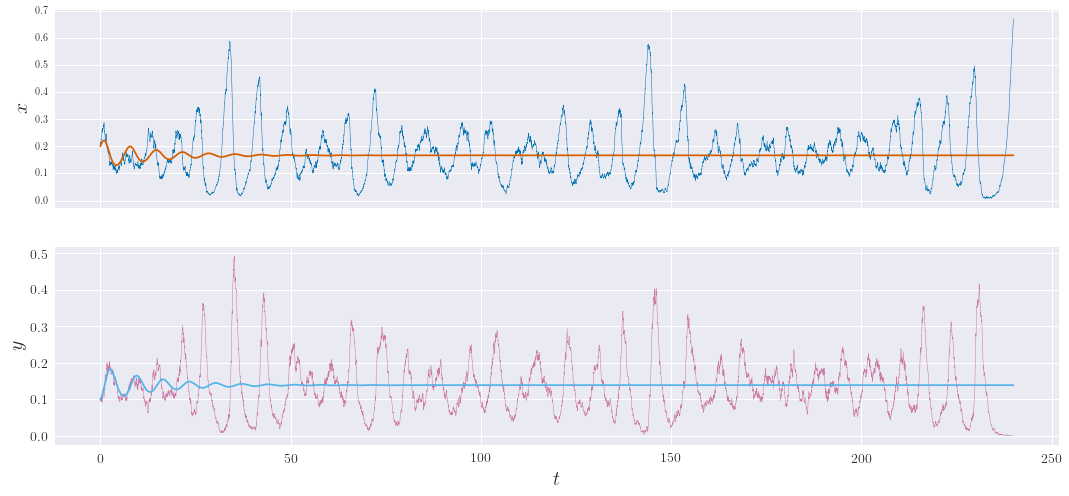

In [6]:
fig, ax = plt.subplots(2, figsize=(18,8), sharex=True)
ax[0].plot(t_full, x_real[:,0], c=colours[0], lw=0.5)
ax[0].plot(t_full, x_det[:,0], c=colours[2])
ax[1].plot(t_full, x_real[:,1], c=colours[3], lw=0.5)
ax[1].plot(t_full, x_det[:,1], c=colours[5])
#ax[0].scatter(artificial_timepoints, artificial_data[:, 0], c=colours[0], s=10)
#ax[1].scatter(artificial_timepoints, artificial_data[:, 1], c=colours[3], s=10)
ax[1].set_xlabel(r'$t$', fontsize=20)
ax[0].set_ylabel(r'$x$', fontsize=20)
ax[1].set_ylabel(r'$y$', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.savefig('toy_data_50.pdf', bbox_inches='tight')

In [7]:
def reconstruct(data, b,g,n,trials=1000,tol=0.01,intersteps=0):
    artificial_timepoints, artificial_data = data
    
    xfix = np.array([1/g,b*(g-1)/g**2])
    Bdet = B(xfix,[0],b,g,n)
    Jdet = J(xfix,[0],b,g,n)
    
    errors = 0
    
    dtt = artificial_timepoints[1]-artificial_timepoints[0]
    dttt = dtt/(intersteps+1)
    
    x0 = np.sqrt(n)*(artificial_data[0]-xfix)
    x = [x0]
    
    noises = []#[np.zeros(ndim)]
    
    for z in (artificial_data[1:]):
        for j in range(trials):
            noise = np.random.multivariate_normal(np.zeros(ndim), Bdet)
            for i in range(intersteps):
                xnew = x0+np.dot(Jdet,x0)*dttt + np.sqrt(dttt)*noise
                x0 = xnew
                noise = np.random.multivariate_normal(np.zeros(ndim), Bdet)
            
            x1 = x0+np.dot(Jdet,x0)*dttt + np.sqrt(dttt)*noise
            err = np.linalg.norm(x1/np.sqrt(n)-(z-xfix))
            if err<tol:
                noises.append(noise)
                break
        else:
            x1 = np.sqrt(n)*(z-xfix)
            errors += 1
        x0 = x1
        x.append(x0)
        noises.append(noise)
    
    errors *= 100./(artificial_data.shape[0]-1)
    covmats = [np.dot(y.reshape(ndim,1),y.reshape(1,ndim)) for y in noises]
    meanB = np.mean(covmats,axis=0)
    
    return {'path': np.array(x)/np.sqrt(n)+xfix, 'norm B': np.linalg.norm(Bdet-meanB), 'error %': errors}

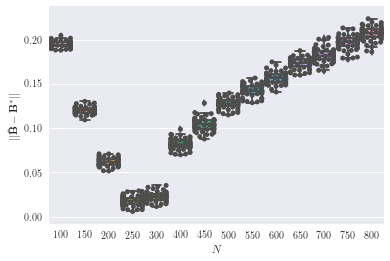

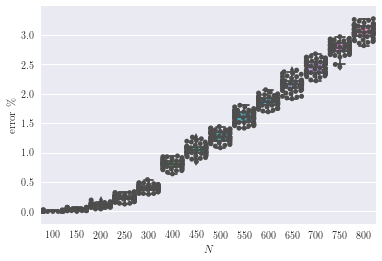

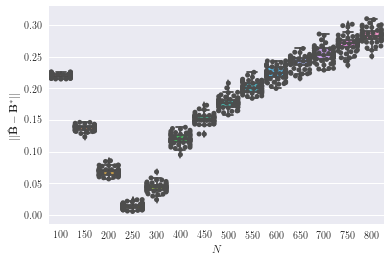

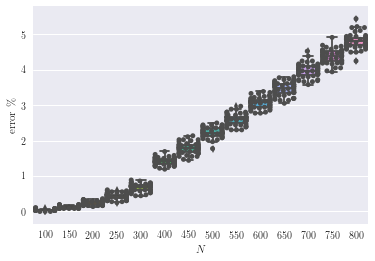

In [10]:
sizes = [100,150,200,250,300,250,400,450,500,550,600,650,700,750,800]
for ss in [1,2]:#,10,20,30,50]:
    measurements = np.arange(0,t_full.shape[0],ss)
    tps = t_full[measurements]
    dps = x_real[measurements]
    data = [tps, dps]
    
    thefails = []
    thenorms = []
    thesizes = []
    for i in range(50):
        for size in sizes:
            rec = reconstruct(data,beta,gamma,size,intersteps=0)
            normB, errors = rec['norm B'], rec['error %']

            thefails.append(errors)
            thenorms.append(normB)
            thesizes.append(size)

    summary = pd.DataFrame({'N':thesizes,'B':thenorms,'error':thefails})
    #summary.to_csv('summary_'+str(ss)+'_noint.csv')
    
    sns.boxplot(x='N', y='B', data=summary)
    sns.swarmplot(x='N', y='B', data=summary, color='0.3')
    plt.ylabel(r'$\vert \vert \mathbf{\hat{B}}-\mathbf{B}^*\vert \vert$')
    plt.xlabel(r'$N$')
    #plt.savefig('norm_'+str(ss)+'_noint.pdf', bbox_inches='tight')
    plt.show()
    
    sns.boxplot(x='N', y='error', data=summary)
    sns.swarmplot(x='N', y='error', data=summary, color='0.3')
    plt.ylabel(r'error \%')
    plt.xlabel(r'$N$')
    #plt.savefig('error_'+str(ss)+'_noint.pdf', bbox_inches='tight')
    plt.show()